In [265]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import numpy as np

In [266]:
problem_class = "FLECC"
f = open(f"../data/datasets/{problem_class}.json")
dataset = json.load(f)
f.close()

In [267]:
def load_folder(folder):
    files = os.listdir(folder)
    res = {}
    for file in files:
        path = os.path.join(folder, file)
        if os.path.isdir(path):
            res[file] = load_folder(path)
        else:
            f = open(path)
            res[file] = json.load(f)
            f.close()
    return res

In [268]:
predictions = load_folder(f"../data/predictions/{problem_class}")

In [269]:
instance_dataset = {}
for datapoint in dataset:
    inst = datapoint["instance_name"]
    times = {t["combination"]: t["time"] for t in datapoint["all_times"]}
    instance_dataset[inst] = times

In [270]:
combinations = [t["combination"] for t in dataset[0]["all_times"]]

In [271]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
metrics = {"accuracy": accuracy_score, "recall": recall_score, "f1": f1_score, "precision": precision_score}

In [272]:
def is_competitive(vb, option):
    return (option < 10 or vb * 2 >= option) and option < 3600

In [273]:
if problem_class == "CarSequencing":
    combinations = [c for c in combinations if not "06_chPrunedLevels.eprime" in c]
combinations = sorted(combinations)

In [274]:
combinations

['chuffed_01_compact.eprime',
 'chuffed_05_nochAllLevels_2.eprime',
 'chuffed_06_chPrunedLevels.eprime',
 'chuffed_07_chAllLevels_1_1_2.eprime',
 'cplex_01_compact.eprime',
 'cplex_05_nochAllLevels_2.eprime',
 'cplex_06_chPrunedLevels.eprime',
 'cplex_07_chAllLevels_1_1_2.eprime',
 'kissat_01_compact.eprime',
 'kissat_05_nochAllLevels_2.eprime',
 'kissat_06_chPrunedLevels.eprime',
 'kissat_07_chAllLevels_1_1_2.eprime',
 'or-tools-1_01_compact.eprime',
 'or-tools-1_05_nochAllLevels_2.eprime',
 'or-tools-1_06_chPrunedLevels.eprime',
 'or-tools-1_07_chAllLevels_1_1_2.eprime']

In [275]:
predictions.keys()

dict_keys(['kmeans_competitive', 'autofolio_tuned_competitive', 'kmeans_fully_neural', 'autofolio_tuned_fully_neural', 'kmeans_fzn2feat', 'autofolio_tuned_fzn2feat', 'fully_neural'])

In [276]:
SAMPLE_KEY = list(predictions.keys())[1]
fold_instances = {"train": {i: [] for i in range(10)}, "validation": {i: [] for i in range(10)}, "test": {i: [] for i in range(10)}} #fold: instances of the fold
for key in predictions[SAMPLE_KEY]:
    strip = key.replace("_predictions_fold", "")
    strip = strip.split("_")
    set_type, fold = strip[0], int(strip[1])
    for pred in predictions[SAMPLE_KEY][key]: 
        instance = pred["inst"]
        fold_instances[set_type][fold].append(instance)

In [279]:
if problem_class == "CarSequencing":
    f = open("../data/features/CarSequencing/car_sequencing_fzn2feat.json")
    _fzn2feat_times = json.load(f)
    f.close()
    fzn2feat_times = {instance["inst"]: instance["time"] for instance in _fzn2feat_times}
else:
    df = pd.read_csv(f"../data/features/{problem_class}/fzn2feat_{problem_class}.csv")
    fzn2feat_times = {df.iloc[i]["inst"]: df.iloc[i]["time"] for i in range(len(df))}
f = open(f"../data/features/{problem_class}/dnn_times.json")
_dnn_times = json.load(f)
f.close()
dnn_times = {instance["inst"]: instance["time"] for instance in _dnn_times}

In [280]:
preditions_dataset = {}
for selection_algorithm in predictions.keys():
    if not selection_algorithm in preditions_dataset:
        preditions_dataset[selection_algorithm] = {}
    for set_type_prediction_fold in predictions[selection_algorithm]:
        strip = set_type_prediction_fold.replace("_predictions_fold", "")
        strip = strip.split("_")
        set_type, fold = strip[0], int(strip[1])
        if not set_type in preditions_dataset[selection_algorithm]:
            preditions_dataset[selection_algorithm][set_type] = {}
        if not fold in preditions_dataset[selection_algorithm][set_type]:
            preditions_dataset[selection_algorithm][set_type][fold] = []
        for pred in predictions[selection_algorithm][set_type_prediction_fold]:
            inst = pred["inst"]
            choosen_option = pred["chosen_option"]
            pred_time = pred["time"] if "time" in pred else 0
            if "fzn2feat" in selection_algorithm:
                pred_time += fzn2feat_times[inst]
            elif "competitive" in selection_algorithm or "fully_neural" in selection_algorithm:
                pred_time += dnn_times[inst]
            else:
                raise Exception(f"wut {selection_algorithm}?")
            if inst in fold_instances[set_type][fold]:
                preditions_dataset[selection_algorithm][set_type][fold].append(
                    instance_dataset[inst][choosen_option] + pred_time
                )
for selection_algorithm in preditions_dataset:
    for set_type in preditions_dataset[selection_algorithm]:
        for fold in preditions_dataset[selection_algorithm][set_type]:
            preditions_dataset[selection_algorithm][set_type][fold] = sum(preditions_dataset[selection_algorithm][set_type][fold])

In [281]:
for combination in combinations:
    preditions_dataset[combination] = {}
    for set_type in fold_instances.keys():
        preditions_dataset[combination][set_type] = {}
        for fold in fold_instances[set_type].keys():
            preditions_dataset[combination][set_type][fold] = []
            for inst in fold_instances[set_type][fold]:
                preditions_dataset[combination][set_type][fold] += [instance_dataset[inst][combination]]
            preditions_dataset[combination][set_type][fold] = sum(preditions_dataset[combination][set_type][fold])
     
preditions_dataset["virtual best"] = {}       
for set_type in fold_instances.keys():
    preditions_dataset["virtual best"][set_type] = {}
    for fold in fold_instances[set_type].keys():
        preditions_dataset["virtual best"][set_type][fold] = []
        for inst in fold_instances[set_type][fold]:
            preditions_dataset["virtual best"][set_type][fold] += [min(instance_dataset[inst].values())]
        preditions_dataset["virtual best"][set_type][fold] = sum(preditions_dataset["virtual best"][set_type][fold])

In [282]:
opt_times = {comb["combination"]:0 for comb in dataset[0]["all_times"]}
for datapoint in dataset:
    for t in datapoint["all_times"]:
        opt_times[t["combination"]] += t["time"]
sb_key = min(opt_times.items(), key = lambda x: x[1])[0]
print(sb_key)

kissat_01_compact.eprime


In [283]:
def key_transform_p1(key):
    if "eprime" in key:
        key = key.replace("0","M").replace("or-tools-1","OR-Tools").replace("5","3").replace("cplex", "CPLEX").replace("chuffed", "Chuffed").replace("kissat", "Kissat")
        return "-".join(key.split("_")[:2])
    else:
        return key.replace("_", "-")
def key_transform(key):
    k = key_transform_p1(key)
    if key != "virtual best":
        string =  "-".join([k.split("-")[-1]] + k.split("-")[:-1])
        return string
    return key.replace("virtual best", "VBS")

In [284]:
def transform(name:str) -> str:
    if "eprime" in name:
        return r"$SB$"
    if "virtual best" in name:
        return r"$VB$"
    if "fully_neural" == name:
        return f"(NN, NN)"
    features = ""
    algorithm = ""
    if "fully_neural" in name:
        features = "NN"
    elif "competitive" in name:
        features = "cNN"
    elif "fzn2feat" in name:
        features = "fzn2feat"
    else:
        raise Exception(f"features {name} unrecognized")
    if "autofolio_untuned" in name:
        algorithm = "A"
    elif "autofolio_tuned" in name:
        algorithm = "A^T"
    elif "kmeans" in name:
        algorithm = "K"
    else:
        raise Exception(f"algorithm {name} unrecognized")
    return fr"(${features}, {algorithm}$)"

In [285]:
comparison = {}
for selection_algorithm in predictions.keys():
    if not "kmeans" in selection_algorithm or "fully_neural" in selection_algorithm:
        continue
    if not selection_algorithm in comparison:
        comparison[selection_algorithm + "_pred_time"] = {}
        comparison[selection_algorithm + "_no_pred_time"] = {}
    for set_type_prediction_fold in predictions[selection_algorithm]:
        strip = set_type_prediction_fold.replace("_predictions_fold", "")
        strip = strip.split("_")
        set_type, fold = strip[0], int(strip[1])
        if set_type != "test":
            continue
        if not fold in comparison[selection_algorithm + "_pred_time"]:
            comparison[selection_algorithm + "_pred_time"][fold] = []
            comparison[selection_algorithm + "_no_pred_time"][fold] = []
        for pred in predictions[selection_algorithm][set_type_prediction_fold]:
            inst = pred["inst"]
            choosen_option = pred["chosen_option"]
            pred_time = pred["time"] if "time" in pred else 0
            if "fzn2feat" in selection_algorithm:
                pred_time += fzn2feat_times[inst]
            elif "competitive" in selection_algorithm:
                pred_time += dnn_times[inst]
            else:
                raise Exception(f"wut {selection_algorithm}?")
            if inst in fold_instances[set_type][fold]:
                comparison[selection_algorithm + "_pred_time"][fold].append(
                    instance_dataset[inst][choosen_option] + pred_time
                )
                comparison[selection_algorithm + "_no_pred_time"][fold].append(
                    instance_dataset[inst][choosen_option]
                )
comp_results = {}
for selection_algorithm in comparison:
    for fold in comparison[selection_algorithm]:
        s = np.average(comparison[selection_algorithm][fold])
        key = "fzn2feat" if "fzn2feat" in selection_algorithm else "cNN"
        key += " + E-time" if not "no_pred_time" in selection_algorithm else ""
        if not key in comp_results:
            comp_results[key] = {}
        comp_results[key][fold] = f"{s:,.2f}"

In [286]:
df = pd.DataFrame(comp_results).sort_index()
df.index.name = "fold"
print(df.to_latex())

\begin{tabular}{lllll}
\toprule
 & cNN + E-time & cNN & fzn2feat + E-time & fzn2feat \\
fold &  &  &  &  \\
\midrule
0 & 203.68 & 203.61 & 154.68 & 154.39 \\
1 & 159.83 & 159.75 & 109.69 & 109.40 \\
2 & 107.98 & 107.90 & 108.24 & 107.95 \\
3 & 105.30 & 105.22 & 105.30 & 105.00 \\
4 & 107.43 & 107.35 & 107.64 & 107.35 \\
5 & 109.92 & 109.84 & 109.66 & 109.36 \\
6 & 102.20 & 102.12 & 102.11 & 101.81 \\
7 & 110.55 & 110.47 & 111.72 & 111.43 \\
8 & 142.13 & 142.05 & 106.77 & 106.48 \\
9 & 154.83 & 154.75 & 154.59 & 154.30 \\
\bottomrule
\end{tabular}



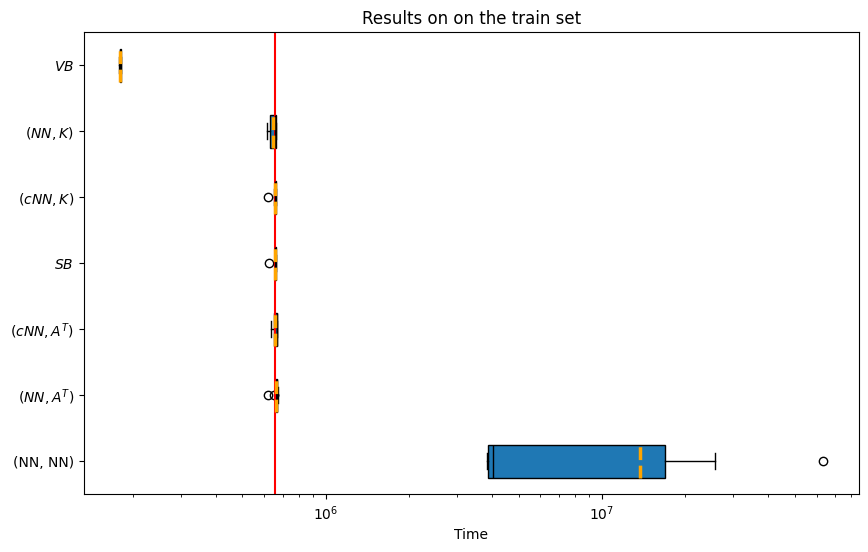

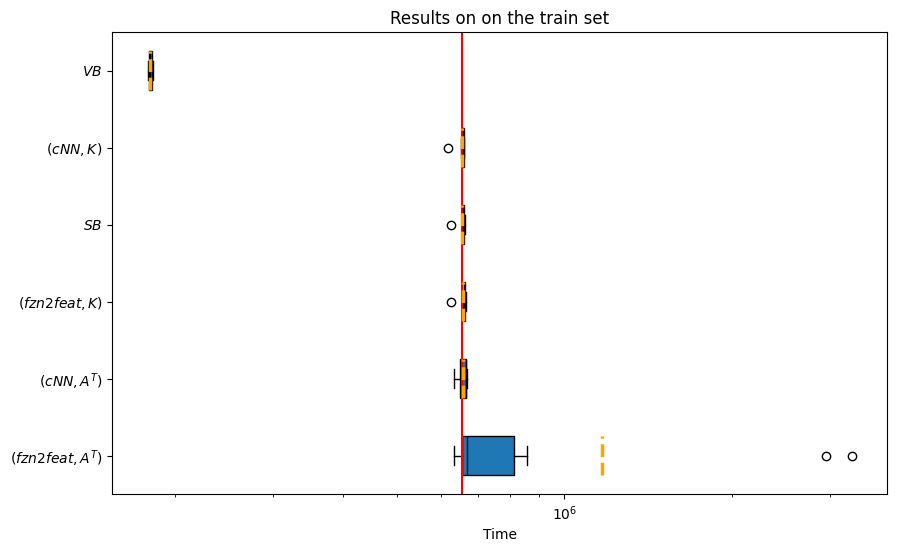

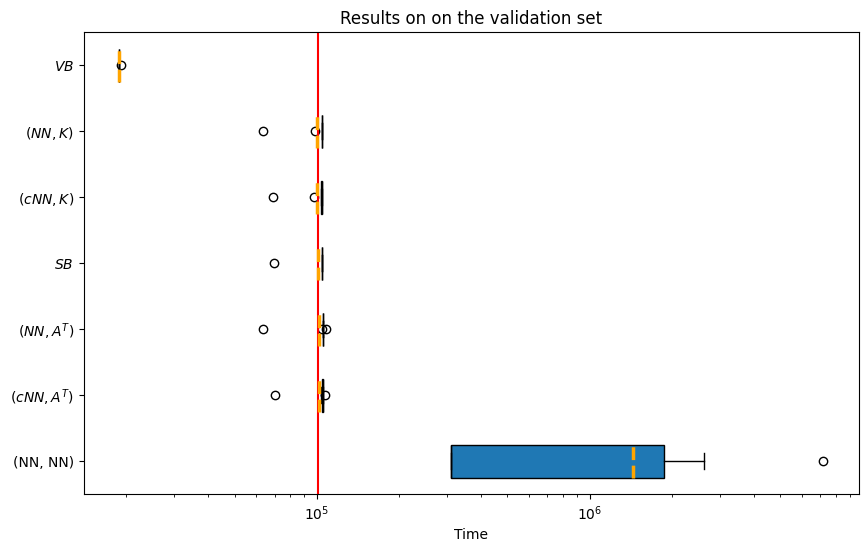

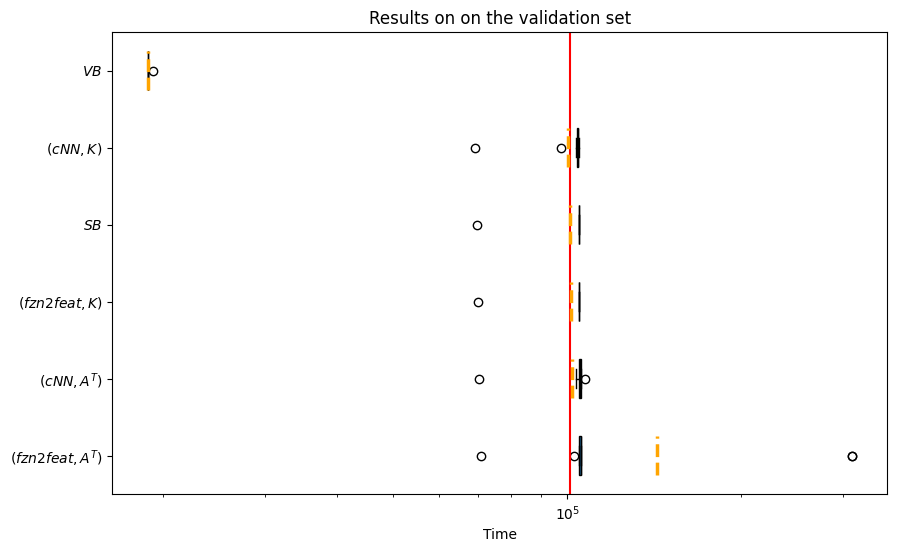

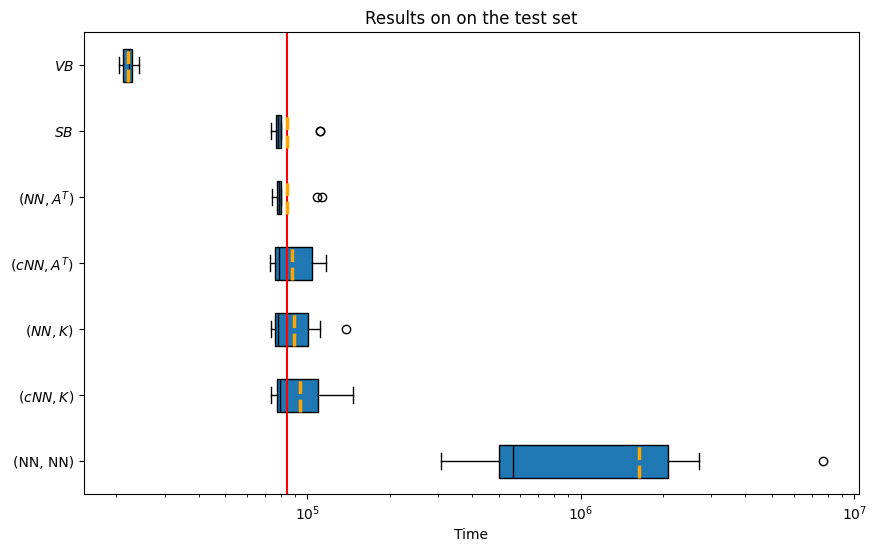

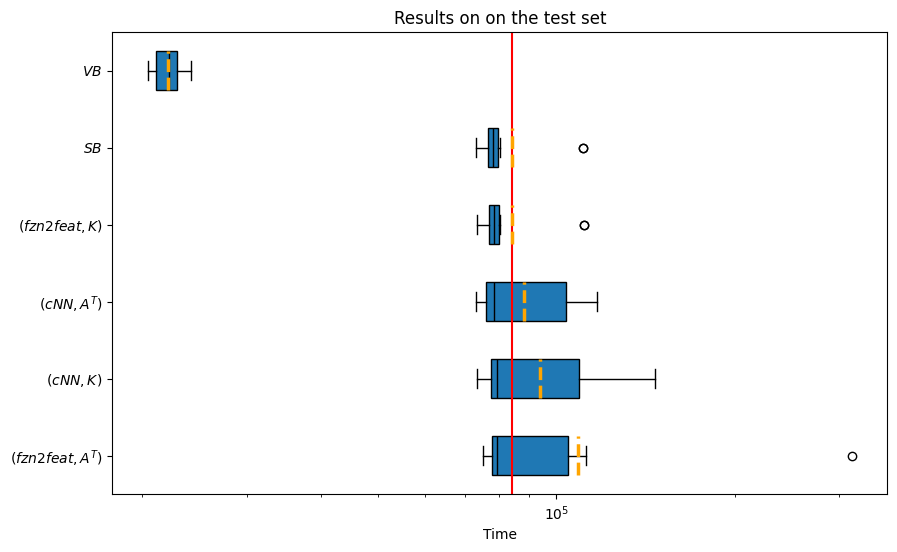

In [287]:
for set_to_use in ["train", "validation", 'test']:
    plot_predictions = {}
    for key in preditions_dataset.keys():
        try:
            if key == sb_key or ("NN" in transform(key) and not "untuned" in key) or key == "virtual best":
                plot_predictions[transform(key)] = list(preditions_dataset[key][set_to_use].values())
        except:
            print(key)

    plot = []

    sorted_data = dict(sorted(plot_predictions.items(), key=lambda item: sum(item[1]) / len(item[1]), reverse=True))

    v_line = np.mean(plot_predictions["$SB$"])
    plt.figure(figsize=(10, 6))
    plt.boxplot(list(sorted_data.values()),
                vert=False,
                patch_artist=True,
                showmeans=True,
                meanprops=dict(linestyle='--', linewidth=2.5, color='orange'),
                boxprops=dict(facecolor="#1F78B4"),
                meanline=True,
                medianprops=dict(color='black'))

    plt.yticks(range(1, len(sorted_data) + 1), list(sorted_data.keys()))

    plt.xscale("log")
    plt.axvline(v_line, color="red")
    plt.xlabel('Time')
    plt.ylabel('')
    plt.title(f"Results on on the {set_to_use} set")
    plt.savefig(f"../data/images/results_{set_to_use}_{problem_class}_NN.pdf", format="pdf", bbox_inches='tight')
    plt.show()
    
    plot_predictions = {}
    for key in preditions_dataset.keys():
        try:
            if key == sb_key or ("fully_neural" not in key and not "untuned" in key and key not in combinations) or key == "virtual best":
                plot_predictions[transform(key)] = list(preditions_dataset[key][set_to_use].values())
        except:
            print(key)

    plot = []

    sorted_data = dict(sorted(plot_predictions.items(), key=lambda item: sum(item[1]) / len(item[1]), reverse=True))
    v_line = np.mean(plot_predictions["$SB$"])
    plt.figure(figsize=(10, 6))
    plt.boxplot(list(sorted_data.values()),
                vert=False,
                patch_artist=True,
                showmeans=True,
                meanprops=dict(linestyle='--', linewidth=2.5, color='orange'),
                boxprops=dict(facecolor="#1F78B4"),
                meanline=True,
                medianprops=dict(color='black'))

    plt.yticks(range(1, len(sorted_data) + 1), list(sorted_data.keys()))

    plt.xscale("log")
    plt.axvline(v_line, color="red")
    plt.xlabel('Time')
    plt.ylabel('')
    plt.title(f"Results on on the {set_to_use} set")
    plt.savefig(f"../data/images/results_{set_to_use}_{problem_class}_comparison.pdf", format="pdf", bbox_inches='tight')
    plt.show()

In [288]:
full_times = {comb: 0 for comb in combinations}
full_times["virtual best"] = 0
for datapoint in dataset:
    for t in datapoint["all_times"]:
        if t["combination"] in full_times:
            full_times[t["combination"]] += t["time"] 
    full_times["virtual best"] += datapoint["time"]
            
full_times = {k:v for k, v in sorted(full_times.items(), key=lambda x: x[1], reverse=True)}

In [289]:
full_times

{'cplex_07_chAllLevels_1_1_2.eprime': 258444203.53999996,
 'cplex_05_nochAllLevels_2.eprime': 258409664.71,
 'kissat_05_nochAllLevels_2.eprime': 257948942.24999994,
 'chuffed_05_nochAllLevels_2.eprime': 257132108.73,
 'or-tools-1_05_nochAllLevels_2.eprime': 256932843.01000002,
 'cplex_01_compact.eprime': 256176535.3199999,
 'cplex_06_chPrunedLevels.eprime': 255996529.32999983,
 'or-tools-1_07_chAllLevels_1_1_2.eprime': 122402404.56000008,
 'or-tools-1_01_compact.eprime': 88794870.27000017,
 'or-tools-1_06_chPrunedLevels.eprime': 87344751.20999989,
 'chuffed_07_chAllLevels_1_1_2.eprime': 46865668.099999875,
 'kissat_07_chAllLevels_1_1_2.eprime': 34909670.609999985,
 'chuffed_06_chPrunedLevels.eprime': 4739616.539999987,
 'chuffed_01_compact.eprime': 4717305.539999989,
 'kissat_06_chPrunedLevels.eprime': 884512.8800000021,
 'kissat_01_compact.eprime': 840876.7799999971,
 'virtual best': 221300.4400000001}

In [290]:
algorithms = set()
for key in full_times.keys():
    if "virtual best" in key:
        continue
    alg = "_".join(key.split("_")[1:])
    algorithms.add(alg)
algorithms = sorted(list(algorithms))
algorithms

['01_compact.eprime',
 '05_nochAllLevels_2.eprime',
 '06_chPrunedLevels.eprime',
 '07_chAllLevels_1_1_2.eprime']

In [291]:
def key_transform_algorithms(key):
    if key == "virtual best":
        return "VBS"
    solver = ""
    if "or-tools-1" in key:
        solver = "OR-Tools"
    elif "cplex" in key:
        solver = "CPLEX"
    elif "chuffed" in key:
        solver = "Chuffed"
    elif "kissat" in key:
        solver = "Kissat"
    else:
        raise Exception(f"solver {key} not found")
    model = "_".join(key.split("_")[1:])
    model = "M" + str(algorithms.index(model) + 1)
    return model + "-" + solver

def key_sorter(x):
    k = key_transform_algorithms(x[0])
    if x[0] != "virtual best":
        return k
    else:
        return "M0"
    
def get_color_solver(k):
    if "chuffed" in k:
        return "#5050d9"
    if "cplex" in k:
        return "#fd1e1c"
    if "or-tools" in k:
        return "#7f0a80"
    if "kissat" in k:
        return "#8b8b8b"
    return "#fd1dfe"

def get_color_model(k):
    if "M1" in k:
        return "#168006"
    if "M2" in k:
        return "#fea61f"
    if "M3" in k:
        return "#a42d2d"
    if "M4" in k:
        return "#828c82"
    return "#fd1dfe"

def key_sorter_model(x):
    if x[0] != "virtual best":
        return x[0]
    else:
        return "M0"

In [292]:
print(format(full_times["virtual best"]/full_times[sb_key], ".2f"))

0.26


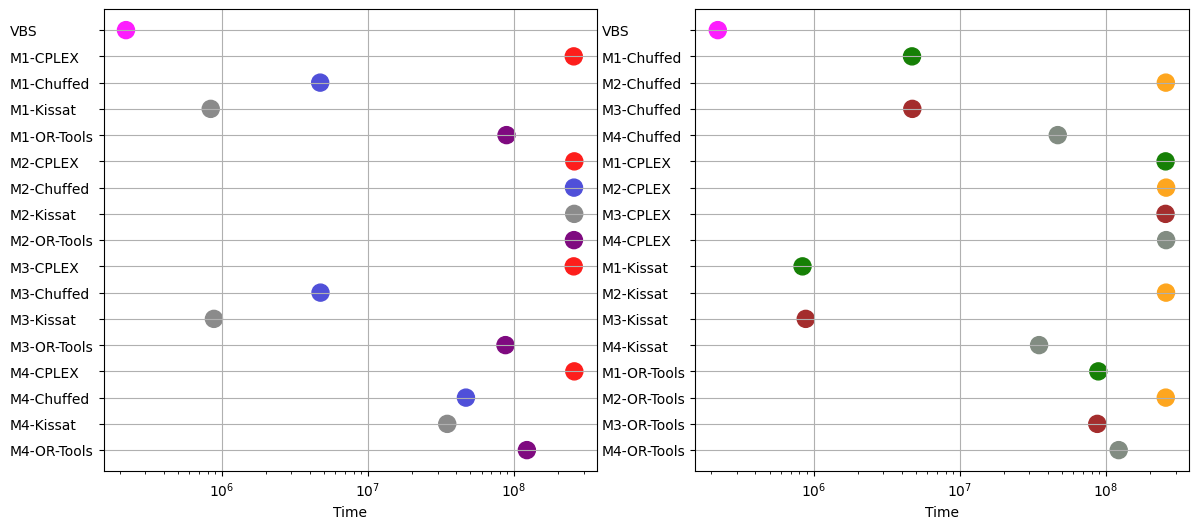

In [293]:
plt.style.use('default')
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
full_times = {k:v for k,v in sorted(full_times.items(), key= key_sorter, reverse=True)}
colors = [get_color_solver(k) for k in full_times.keys()]
s = [150 for _ in range(len(full_times.keys()))]
pad_len = max([len(key_transform_algorithms(k)) for  k in full_times.keys()])
axs[0].scatter(list(full_times.values()), [key_transform_algorithms(k) for  k in full_times.keys()], c=colors, s=s)
axs[0].grid(True)
for label in axs[0].get_yticklabels():
    label.set_ha('left')
    label.set_position((-0.17,0))
axs[0].set_xscale("log")
axs[0].set_xlabel("Time")

full_times = {k:v for k,v in sorted(full_times.items(), key= key_sorter_model, reverse=True)}
colors = [get_color_model(key_transform_algorithms(k)) for k in full_times.keys()]
s = [150 for _ in range(len(full_times.keys()))]
axs[1].scatter(list(full_times.values()), [key_transform_algorithms(k) for  k in full_times.keys()], c=colors, s=s)
axs[1].grid(True)
for label in axs[1].get_yticklabels():
    label.set_ha('left')
    label.set_position((-0.17,0))
axs[1].set_xscale("log")
axs[1].set_xlabel("Time")
fig.savefig(f"../data/images/algorithm_time{problem_class}.pdf", format="pdf", bbox_inches='tight')

In [294]:
all_wins = {comb: 0 for comb in combinations}
for datapoint in dataset:
    win_comb = datapoint["combination"]
    win_comb = win_comb.replace("06_chPrunedLevels", "01_compact")
    all_wins[win_comb] += 1

all_wins = {comb: v/len(dataset) for comb, v in all_wins.items()}
all_wins

{'chuffed_01_compact.eprime': 0.9676658340271995,
 'chuffed_05_nochAllLevels_2.eprime': 0.0,
 'chuffed_06_chPrunedLevels.eprime': 0.0,
 'chuffed_07_chAllLevels_1_1_2.eprime': 0.0002775464890369137,
 'cplex_01_compact.eprime': 0.002497918401332223,
 'cplex_05_nochAllLevels_2.eprime': 0.0,
 'cplex_06_chPrunedLevels.eprime': 0.0,
 'cplex_07_chAllLevels_1_1_2.eprime': 0.0,
 'kissat_01_compact.eprime': 0.029142381348875937,
 'kissat_05_nochAllLevels_2.eprime': 0.0,
 'kissat_06_chPrunedLevels.eprime': 0.0,
 'kissat_07_chAllLevels_1_1_2.eprime': 0.0002775464890369137,
 'or-tools-1_01_compact.eprime': 0.0,
 'or-tools-1_05_nochAllLevels_2.eprime': 0.0,
 'or-tools-1_06_chPrunedLevels.eprime': 0.0,
 'or-tools-1_07_chAllLevels_1_1_2.eprime': 0.00013877324451845685}

In [295]:
def is_competitive(vb, opt):
    return (opt < 3600 and vb * 2 >= opt) or opt < 10

all_competitive = {comb: 0 for comb in combinations}
for datapoint in dataset:
    for t in datapoint["all_times"]:
        if not "06_chPrunedLevels" in t["combination"]:
            if is_competitive(datapoint["time"], t["time"]):
                all_competitive[t["combination"]] += 1
all_competitive = {comb: v/len(dataset) for comb, v in all_competitive.items()}
all_competitive

{'chuffed_01_compact.eprime': 0.9750208159866778,
 'chuffed_05_nochAllLevels_2.eprime': 0.00013877324451845685,
 'chuffed_06_chPrunedLevels.eprime': 0.0,
 'chuffed_07_chAllLevels_1_1_2.eprime': 0.005828476269775187,
 'cplex_01_compact.eprime': 0.012489592006661115,
 'cplex_05_nochAllLevels_2.eprime': 0.0,
 'cplex_06_chPrunedLevels.eprime': 0.0,
 'cplex_07_chAllLevels_1_1_2.eprime': 0.0033305578684429643,
 'kissat_01_compact.eprime': 0.11781848459616986,
 'kissat_05_nochAllLevels_2.eprime': 0.00013877324451845685,
 'kissat_06_chPrunedLevels.eprime': 0.0,
 'kissat_07_chAllLevels_1_1_2.eprime': 0.006938662225922842,
 'or-tools-1_01_compact.eprime': 0.004301970580072162,
 'or-tools-1_05_nochAllLevels_2.eprime': 0.0,
 'or-tools-1_06_chPrunedLevels.eprime': 0.0,
 'or-tools-1_07_chAllLevels_1_1_2.eprime': 0.0019428254232583958}

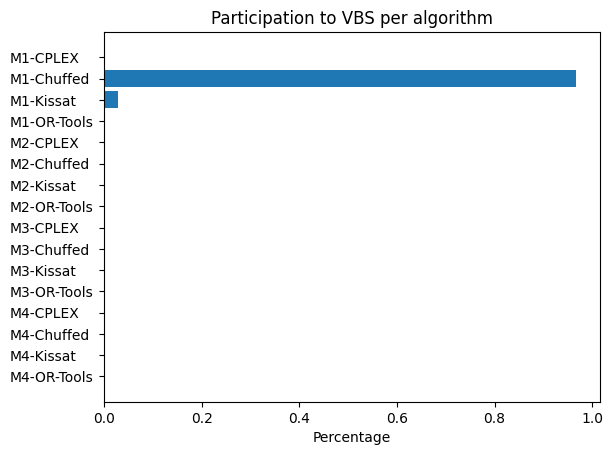

In [296]:
all_wins = {k:v for k,v in sorted(all_wins.items(), key=lambda x: key_transform_algorithms(x[0]), reverse=True)}
plt.style.use('default')
plt.barh([key_transform_algorithms(k) for k in all_wins.keys()], list(all_wins.values()))
for label in plt.gca().get_yticklabels():
    label.set_ha('left')
    label.set_position((-0.17,0))
plt.title("Participation to VBS per algorithm")
plt.xlabel("Percentage")
plt.savefig(f"../data/images/algorithm_wins_vb{problem_class}.pdf", format="pdf", bbox_inches='tight')

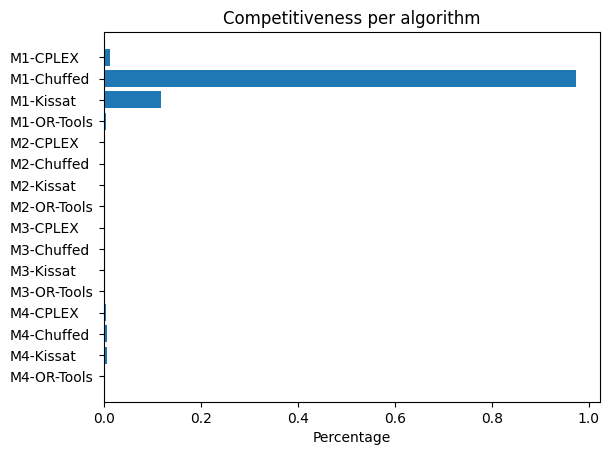

In [297]:
all_competitive = {k:v for k,v in sorted(all_competitive.items(), key=lambda x: key_transform_algorithms(x[0]), reverse=True)}
plt.barh([key_transform_algorithms(k) for k in all_competitive.keys()], list(all_competitive.values()))
for label in plt.gca().get_yticklabels():
    label.set_ha('left')
    label.set_position((-0.17,0))
plt.xlabel("Percentage")
plt.title("Competitiveness per algorithm")
plt.savefig(f"../data/images/algorithm_comp_vb{problem_class}.pdf", format="pdf", bbox_inches='tight')

In [ ]:
training_data = {}
for file in os.listdir("../history"):
    if "extra" in file:
        continue
    fold = file.split("_mult_")[0].replace("fold_","")
    mult = 2 if "2" in file.split("_mult_")[1] else 1
    time = "init" if "init" in file.split("_mult_")[1] else "fin"
    if not fold in training_data:
        training_data[fold] = {}
    f = open(os.path.join("../history", file))
    if mult == 2:
        training_data[fold][0] = json.load(f)
    elif mult == 1:
        if time == "init":
            training_data[fold][1] = json.load(f)
        else:
            training_data[fold][2] = json.load(f)
    f.close()

In [ ]:
for fold in training_data.keys():
    res = []
    for i in range(3):
        res += [training_data[fold][i]]
    training_data[fold] = res

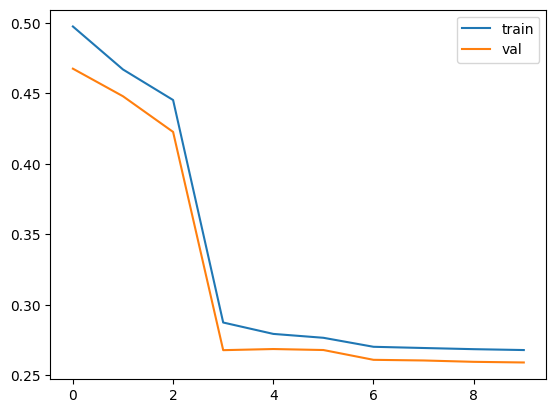

In [ ]:
loss_train = []
loss_val = []
for v in training_data["7"]:
    loss_train += v["train"]["loss"]
    loss_val += v["validation"]["loss"]
x = [i for i in range(len(loss_train))]
plt.plot(x, loss_train, label="train")
plt.plot(x, loss_val, label="val")
plt.legend()
plt.show()

In [291]:
training_data = {}
for file in os.listdir("../history"):
    if "extra" in file:
        continue
    fold = file.split("_mult_")[0].replace("fold_","")
    mult = 2 if "2" in file.split("_mult_")[1] else 1
    time = "init" if "init" in file.split("_mult_")[1] else "fin"
    if not fold in training_data:
        training_data[fold] = {}
    f = open(os.path.join("../history", file))
    if mult == 2:
        training_data[fold][0] = json.load(f)
    elif mult == 1:
        if time == "init":
            training_data[fold][1] = json.load(f)
        else:
            training_data[fold][2] = json.load(f)
    f.close()
for fold in training_data.keys():
    res = []
    for i in range(3):
        res += [training_data[fold][i]]
    training_data[fold] = res


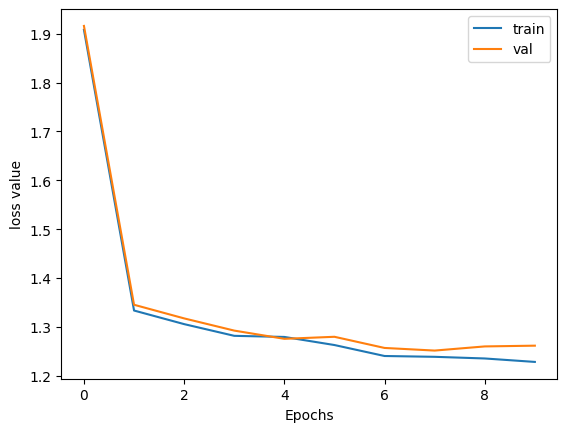

In [ ]:
loss_train = []
loss_val = []
for v in training_data["0"]:
    loss_train += v["train"]["loss"]
    loss_val += v["validation"]["loss"]
x = [i for i in range(len(loss_train))]
plt.plot(x, loss_train, label="train")
plt.plot(x, loss_val, label="val")
plt.xlabel("Epochs")
plt.legend()
plt.ylabel("loss value")
plt.savefig(f"loss_folds_0.pdf", format="pdf")
plt.show()

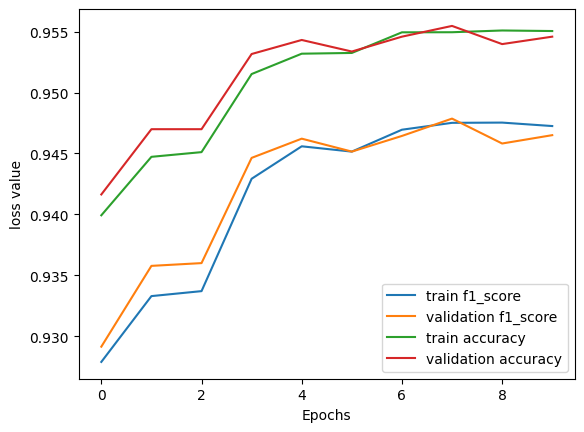

In [292]:
metrics = ["f1_score", "accuracy"]
m_data = {m: {"train": [], "validation": []} for m in metrics}
for v in training_data["0"]:
    for m in metrics:
        m_data[m]["train"] += v["train"][m]
        m_data[m]["validation"] += v["validation"][m]
x = [i for i in range(10)]
for m in metrics:
    plt.plot(x, m_data[m]["train"], label=f"train {m}")
    plt.plot(x, m_data[m]["validation"], label=f"validation {m}")
plt.xlabel("Epochs")
plt.legend()
plt.ylabel("loss value")
plt.savefig(f"metrics_folds_0.pdf", format="pdf")
plt.show()

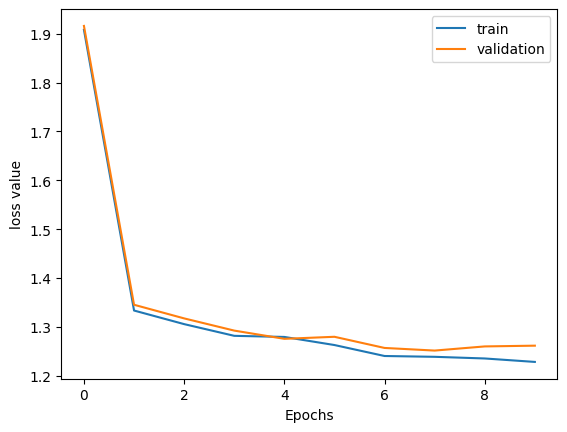

In [ ]:

training_data = {}
for file in os.listdir("../faulty_data"):
    if "extra" in file:
        continue
    fold = file.split("_mult_")[0].replace("fold_","")
    mult = 2 if "2" in file.split("_mult_")[1] else 1
    time = "init" if "init" in file.split("_mult_")[1] else "fin"
    if not fold in training_data:
        training_data[fold] = {}
    f = open(os.path.join("../faulty_data", file))
    if mult == 2:
        training_data[fold][0] = json.load(f)
    elif mult == 1:
        if time == "init":
            training_data[fold][1] = json.load(f)
        else:
            training_data[fold][2] = json.load(f)
    f.close()
for fold in training_data.keys():
    res = []
    for i in range(3):
        res += [training_data[fold][i]]
    training_data[fold] = res
loss_train = []
loss_val = []
for v in training_data["0"]:
    loss_train += v["train"]["loss"]
    loss_val += v["validation"]["loss"]
x = [i for i in range(len(loss_train))]
plt.plot(x, loss_train, label="train")
plt.plot(x, loss_val, label="validation")
plt.xlabel("Epochs")
plt.legend()
plt.ylabel("loss value")
plt.savefig("loss_fully_neural_0.pdf", format="pdf")
plt.show()

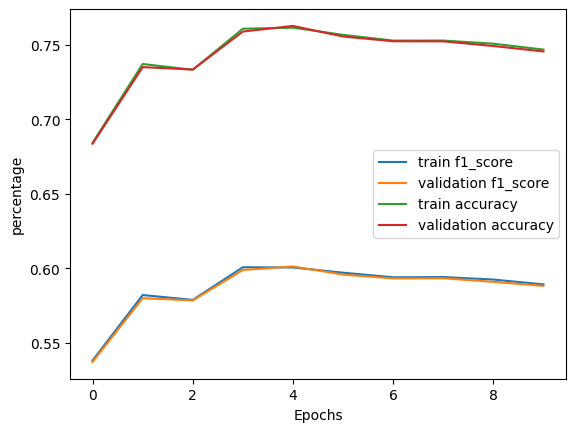

In [ ]:

metrics = ["f1_score", "accuracy"]
m_data = {m: {"train": [], "validation": []} for m in metrics}
for v in training_data["0"]:
    for m in metrics:
       m_data[m]["train"] += v["train"][m]
       m_data[m]["validation"] += v["validation"][m]
x = [i for i in range(10)]
for m in metrics:
    plt.plot(x, m_data[m]["train"], label=f"train {m}")
    plt.plot(x, m_data[m]["validation"], label=f"validation {m}")
plt.xlabel("Epochs")
plt.legend()
plt.ylabel("percentage")
plt.savefig("metrics_fully_neural_0.pdf", format="pdf")
plt.show()